In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from ssd.config import cfg
import numpy as np

from ssd.data.transforms import build_transforms
from ssd.modeling.detector import build_detection_model
from ssd.utils.checkpoint import CheckPointer

### Load model

In [2]:
cfg.merge_from_file('configs/mobilenet_v2_ssd320_japan_heads.yaml')
cfg.freeze()

device = torch.device(cfg.MODEL.DEVICE)

model = build_detection_model(cfg)
model = model.to(device)

### Load weights

In [3]:
ckpt = 'final'
checkpointer = CheckPointer(model, save_dir=cfg.OUTPUT_DIR)
checkpointer.load(ckpt)

weight_file = ckpt if ckpt else checkpointer.get_checkpoint_file()
print('Loaded weights from {}'.format(weight_file))

Loaded weights from final


### Load preprocessing transformations and set model to eval

In [4]:
cpu_device = torch.device("cpu")
transforms = build_transforms(cfg, is_train=False)
model = model.eval()

### Infer

In [60]:
# img = np.array(Image.open('../data/JapanHeads/val/18100.jpg').convert("RGB"))
img = cv2.imread('../data/JapanHeads/val/18100.jpg')
# img = cv2.imread('../data/JapanHeads/without_annotation/10.jpg')
height, width = img.shape[:2]
images = transforms(img[::,::,::-1])[0].unsqueeze(0)
result = model(images.to(device))[0]
result = result.resize((width, height))
result

{'boxes': tensor([[622.2898, 144.5001, 693.1730, 211.2545]], device='cuda:0',
       grad_fn=<CopySlices>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2509], device='cuda:0', grad_fn=<CatBackward>)}

In [61]:
# xmin,ymin,xmax,ymax
boxes = result['boxes'].cpu().detach().numpy().astype(np.int32)
labels = result['labels'].cpu().detach().numpy()
scores = result['scores'].cpu().detach().numpy()
print(" BOXES:  {}\n LABELS: {}\n SCORES: {}\n".format(boxes, labels, scores))

 BOXES:  [[622 144 693 211]]
 LABELS: [1]
 SCORES: [0.25088254]



### Measure speed

In [68]:
import numpy as np
from typing import Tuple


def one_inf_timeit(model, img):
    "proper way to test pytorch speed"
    torch.cuda.synchronize()
    model(img)
    torch.cuda.synchronize()
    

def get_random_image(shape: Tuple[int, int, int]) -> 'np.ndarray':
    """ Generate image of random noise

        :param shape: ``(height, width, channels_num)``
    """
    img = (np.random.standard_normal(shape) * 255).astype(np.uint8)
    return img

In [92]:
# no heads
tmp = get_random_image((800, 800, 3))
# 4 heads
# tmp = cv2.imread('../data/JapanHeads/val/12660.jpg')
# 3 heads
# tmp = cv2.imread('../data/JapanHeads/val/11810.jpg')
# 2 heads
# tmp = cv2.imread('../data/JapanHeads/val/11600.jpg')
# 1 head
# tmp = cv2.imread('../data/JapanHeads/val/11890.jpg')
images = transforms(tmp)[0].unsqueeze(0).to(device)
result = model(images)[0]

In [93]:
result

{'boxes': tensor([[266.5766, 247.8599, 291.5484, 299.7392],
        [278.4569, 298.0273, 299.7634, 321.4557],
        [236.5461, 298.2168, 272.0642, 325.3221],
        [185.3083, 103.5119, 212.0902, 161.9665],
        [122.0137, 181.0517, 394.9421, 309.6594],
        [-10.4037, -76.6183, 162.1928, 231.3325],
        [266.4202, 137.5987, 291.6492, 187.7287],
        [266.3672, 169.4090, 291.3798, 219.4443],
        [289.3322, 106.8751, 312.3366, 138.1237],
        [-72.8196, 151.5488, 229.2905, 306.9632],
        [126.6672,  33.5477, 387.3025, 269.7906],
        [ 99.2787,  90.8285, 415.7716, 199.5222],
        [ 54.3121,  -2.6096, 397.6073, 181.2968],
        [188.7678,  89.0289, 304.6007, 401.8643],
        [  7.3673,  86.1046, 149.3089, 382.9861],
        [147.4899, -68.0802, 302.1010, 227.7193]], device='cuda:0',
       grad_fn=<CatBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0257, 0.0158, 0.0136, 0.0125, 0.0123

In [95]:
# speed does not differ from 1 to 16 objects on image (I did not test >16)
%%timeit
one_inf_timeit(model, images)

7.77 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [79]:
# FPS
1000/11.3

88.49557522123894

## Plot on video

### Define drawing function

In [52]:
def SSD_predict(frame, model):
    height, width = frame.shape[:2]
    blob = transforms(frame[::,::,::-1])[0].unsqueeze(0)
    result = model(blob.to(device))[0]
    result = result.resize((width, height))
    boxes = result['boxes'].cpu().detach().numpy().astype(np.int32)
    labels = result['labels'].cpu().detach().numpy()
    scores = result['scores'].cpu().detach().numpy()
    
    for i in range(len(boxes)):
        b = boxes[i]
        s = scores[i]
        if s > 0.2:
            p1 = tuple(b[:2])
            p2 = tuple(b[2:])
            cv2.rectangle(frame, p1, p2, (0, 123, 255), 4)
            cv2.putText(frame, "{:.02f}".format(s), (p1[0], p1[1] - 2),
                        cv2.FONT_HERSHEY_COMPLEX, 0.75, (0,255,0))
    return frame

### Test

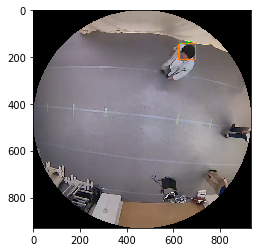

In [53]:
img = cv2.imread('../data/JapanHeads/val/18100.jpg')
# img = cv2.imread('../data/JapanHeads/without_annotation/10.jpg')
tmp = SSD_predict(img, model)
plt.imshow(tmp[::,::,::-1])

### Get video wrapper

In [54]:
import cv2
import magic
import os
from tqdm import tqdm
import numpy as np
import functools
from typing import Callable


def videowriter_wrapper(func: 'Callable', IN: str, OUT: str, CODEC: str = "MP4V",
                        out_shape: tuple = None, time: int = None,
                        from_frame: int = None, *args, **kwargs) -> 'Callable':
    """ :param func: function in form ``func(frame, *args, **kwargs) -> frame``
        :param IN: file or rtsp stream
        :param OUT: file name
        :param CODEC: ``"MP4V"`` or ``"MJPG"`` or (``"H264"`` not for opencv-python), defaults to ``"MP4V"``
        :param out_shape: ``tuple(width, height)``, defaults to ``None``
        :param time: seconds to crop from start, defaults to ``None``
        :param from_frame: start frame position, defaults to ``None``

        **Examples:**

        .. code-block:: python

            write_15s = videowriter_wrapper(lambda x: x, path_img, out_path, time=15)
            write_15s()

            process_video = videowriter_wrapper(plot_persons, args.IN, args.OUT)
            process_video(yolo, model, shape=(224, 224))
    """
    @functools.wraps(func)
    def inner(*args, **kwargs):
        # open input file
        INPUT = cv2.VideoCapture(IN)
        if out_shape:
            W, H = out_shape
        else:
            W = int(INPUT.get(cv2.CAP_PROP_FRAME_WIDTH))
            H = int(INPUT.get(cv2.CAP_PROP_FRAME_HEIGHT))
        FPS = float(INPUT.get(cv2.CAP_PROP_FPS))
        if time:
            TARGET_FRAMES = int(FPS * time)
            if from_frame:
                delta = int(from_frame)
                INPUT.set(cv2.CAP_PROP_POS_FRAMES, delta)
        else:
            TARGET_FRAMES = int(INPUT.get(cv2.CAP_PROP_FRAME_COUNT))
            if from_frame:
                delta = int(from_frame)
                INPUT.set(cv2.CAP_PROP_POS_FRAMES, delta)
                TARGET_FRAMES -= delta

        # open output file
        fourcc = cv2.VideoWriter_fourcc(*CODEC)
        writer = cv2.VideoWriter(OUT, fourcc, FPS, (W, H), True)

        # process every frame
        for i in tqdm(range(TARGET_FRAMES)):
            if INPUT.isOpened():
                grabbed, frame = INPUT.read()
                ###
                frame = func(frame, *args, **kwargs)
                ###
                if out_shape:
                    frame = cv2.resize(frame, out_shape)
                writer.write(frame)
        # close files
        writer.release()
        INPUT.release()
    return inner

In [55]:
process_video = videowriter_wrapper(SSD_predict,
                                    'cropped.mp4',
                                    'out.mp4',
                                    time=10)

### Process

In [56]:
process_video(model)

100%|██████████| 300/300 [00:05<00:00, 53.63it/s]
